In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import exp, inf, tanh
from numpy import mean, std
from scipy.stats import norm
from scipy.signal import savgol_filter

In [3]:
class ChangePointSequence:
    def __init__(self, N, mean, standard_deviation, change_point_position):
        self.N = N
        self.counter = -1
        self.mean = mean
        self.standard_deviation = standard_deviation
        self.change_point_position = change_point_position
        self.sequence = []
        
    def __iter__(self):
        return self
    
    def __next__(self):
        pass

    
class NoChangePoint(ChangePointSequence):
    '''
    Потоковая генерация случайной последовательности без разладки.
    '''
    def __init__(self, N, mean, standard_deviation):
        super().__init__(N, mean, standard_deviation, 0)
        
    def __next__(self):
        if self.counter < self.N:
            self.counter += 1
            new_element_sequence = float(norm.rvs(loc=self.mean, scale=self.standard_deviation, size=1))             
            self.sequence.append(new_element_sequence)
            return new_element_sequence
        else:
            raise StopIteration
    

class ChagePointMean(ChangePointSequence):
    '''
    Потоковая генерация случайной последовательности с разладкой в М.О.
    '''
    def __init__(self, N, mean, standard_deviation, change_point_position, mean_change):
        super().__init__(N, mean, standard_deviation, change_point_position)
        self.mean_change = mean_change
        
    def __next__(self):
        if self.counter < self.N:
            
            self.counter += 1
            
            new_element_sequence = float(norm.rvs(loc=self.mean, scale=self.standard_deviation, size=1)) \
            if self.counter <= self.change_point_position \
            else float(norm.rvs(loc=(self.mean+self.mean_change), scale=self.standard_deviation, size=1))
            
            self.sequence.append(new_element_sequence)
            return new_element_sequence
        
        else:
            raise StopIteration
            
            
class ChagePointMeanDynamic(ChangePointSequence):
    '''
    Потоковая генерация случайной последовательности с разладкой в М.О.
    '''
    def __init__(self, N, mean, standard_deviation, change_point_position, mean_change):
        super().__init__(N, mean, standard_deviation, change_point_position)
        self.mean_change = mean_change
        
    def __next__(self):
        if self.counter < self.N:
            
            self.counter += 1
            
            new_element_sequence = float(norm.rvs(loc=self.mean, scale=self.standard_deviation, size=1)) \
            if self.counter <= self.change_point_position \
            else float(norm.rvs(loc=(self.mean+self.mean_change*(self.counter-self.change_point_position)),
                                scale=self.standard_deviation,
                                size=1))
            
            self.sequence.append(new_element_sequence)
            return new_element_sequence
            
        else:
            raise StopIteration
            
            
class ChagePointDispersion(ChangePointSequence):
    '''
    Потоковая генерация случайной последовательности с разладкой в дисперсии
    '''
    def __init__(self, N, mean, standard_deviation, change_point_position, standard_deviation_change):
        super().__init__(N, mean, standard_deviation, change_point_position)
        self.standard_deviation_change = standard_deviation_change
        
    def __next__(self):
        if self.counter < self.N:
            
            self.counter += 1
            
            new_element_sequence = float(norm.rvs(loc=self.mean, scale=self.standard_deviation, size=1)) \
            if self.counter <= self.change_point_position \
            else float(norm.rvs(loc=self.mean, scale=(self.standard_deviation+self.standard_deviation_change), size=1))
            
            self.sequence.append(new_element_sequence)
            return new_element_sequence
        
        else:
            raise StopIteration    

In [4]:
def algorithm_grsh(seq, g, k):
    R = [0]
    
    # Заполняем изначальными значениями
    while len(sequence.sequence) < k:
        new_value = next(sequence)

    from numpy import mean, std
    m = mean(sequence.sequence)
    s = np.std(sequence.sequence)
    v = (abs(m) + 2*s) 
    
    for new_value in seq:
        Rt = exp(new_value - v) * (1 + R[-1])
        if Rt > g:
            #print('changepoint', seq.counter - 1, 'Rt =', Rt)
            return seq.counter - 1
        R.append(Rt)
    #print('No change points.')
    return -1


# Алгоритм Воробейчикова
def algorithm_change_point_St(seq, difference_step_count, t0=300, m=1, N=8):

    def z_n(N, m, x, t, t0):
        def sign(x):
            return 1 if x >= 0 else -1

        def y_n(x, t, t0):
            return sign(x[t] - x[t-t0])

        return N * y_n(x, t, t0) - m
    
    def dcp(difference_step_count, difference):
        if len(difference) < difference_step_count:
            return False
        previous = None
        for i in range(difference_step_count-1):
            if difference[-1-i] != difference[-2-i]:
                return False
        return True
    
    
    l = N + m
    Sn = []
    t = 0
    x = []
    difference = []
    
    while t <= t0:
        x.append(next(sequence))
        Sn.append(l)
        t += 1

    for new_value in sequence:
        x.append(new_value)
        zn = z_n(N, m, x, t, t0)
        current_Sn = max(Sn[-1] + zn, l)
        difference.append((current_Sn - Sn[-1]))
        if dcp(difference_step_count, difference):
            return (t, t - difference_step_count)

        Sn.append(current_Sn)
        t += 1
        
    return (-1, -1)

# Варьируем коэф. а (2)

In [30]:
%%time
# Показатели среднего времени запаздывания
lst_grsh_t = []
# Показатели относительной частоты ложного обнаружения
lst_grsh_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_grsh_sigma = []
# При различных значениях а
lst_a = [a/20 for a in range(2, 19, 1)]
cpp = 600
N = 1000

for a in lst_a:
    # Для ГРШ
    lst = []
    for i in range(N):    
        sequence = ChagePointMeanDynamic(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            mean_change=a
        )

        result = algorithm_grsh(seq=sequence, g=12, k=100)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_grsh_t.append(average_lag_time)
    lst_grsh_w.append(false_detection_probability)
    lst_grsh_sigma.append(std_time)

Wall time: 12min 52s


In [31]:
# Показатели среднего времени запаздывания
lst_vrb_t = []
# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_vrb_sigma = []

for a in lst_a:    
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMeanDynamic(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            mean_change=a
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=10)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_vrb_t.append(average_lag_time)
    lst_vrb_w.append(false_detection_probability)
    lst_vrb_sigma.append(std_time)

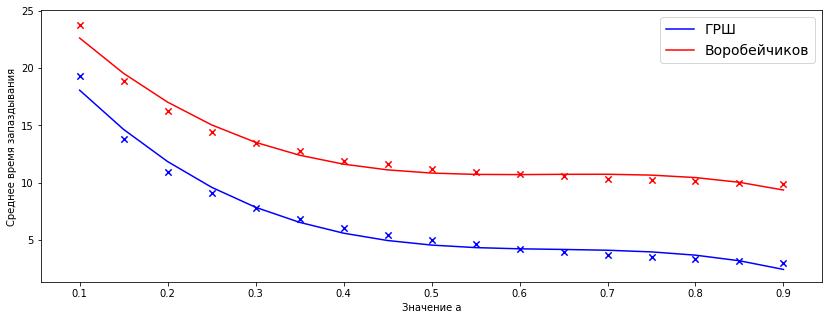

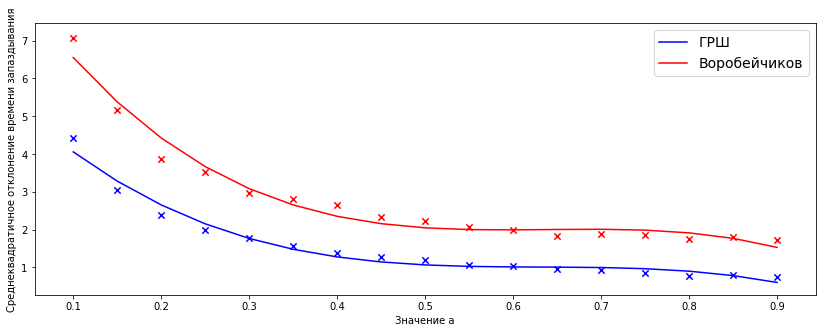

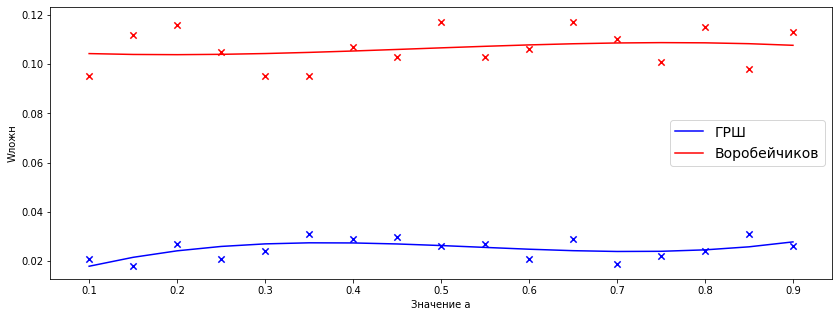

In [44]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее время запаздывания')
plt.xlabel('Значение а')

sns.lineplot(x=lst_a, 
             y=savgol_filter(lst_grsh_t, len(lst_a), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_a, lst_grsh_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_a, 
             y=savgol_filter(lst_vrb_t, len(lst_a), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_a, lst_vrb_t, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение времени запаздывания')
plt.xlabel('Значение а')

sns.lineplot(x=lst_a, 
             y=savgol_filter(lst_grsh_sigma, len(lst_a), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_a, lst_grsh_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_a, 
             y=savgol_filter(lst_vrb_sigma, len(lst_a), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_a, lst_vrb_sigma, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение а')

sns.lineplot(x=lst_a, 
             y=savgol_filter(lst_grsh_w, len(lst_a), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_a, lst_grsh_w, color='blue', s=40, marker='x')

sns.lineplot(x=lst_a, 
             y=savgol_filter(lst_vrb_w, len(lst_a), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_a, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Варьируем среднеквадратичное (2)

In [45]:
%%time
# Показатели среднего времени запаздывания
lst_grsh_t = []
# Показатели относительной частоты ложного обнаружения
lst_grsh_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_grsh_sigma = []
# При различных значениях сигма
lst_sig = [a/20 for a in range(10, 31, 1)]
cpp = 600
N = 1000

for sig in lst_sig:
    # Для ГРШ
    lst = []
    for i in range(N):    
        sequence = ChagePointMeanDynamic(
            N=1000,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=0.5
        )

        result = algorithm_grsh(seq=sequence, g=12, k=100)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_grsh_t.append(average_lag_time)
    lst_grsh_w.append(false_detection_probability)
    lst_grsh_sigma.append(std_time)

Wall time: 13min 24s


In [46]:
%%time
# Показатели среднего времени запаздывания
lst_vrb_t = []
# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_vrb_sigma = []

for sig in lst_sig: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMeanDynamic(
            N=1000,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=0.5
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=10)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_vrb_t.append(average_lag_time)
    lst_vrb_w.append(false_detection_probability)
    lst_vrb_sigma.append(std_time)

Wall time: 14min 3s


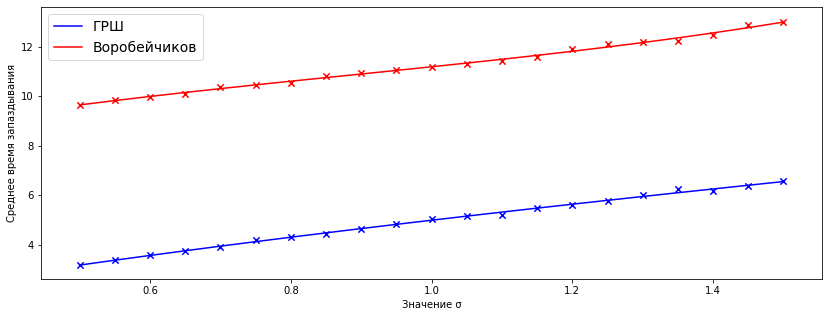

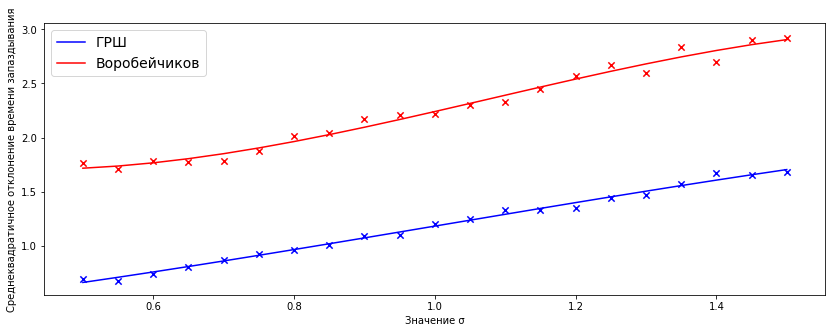

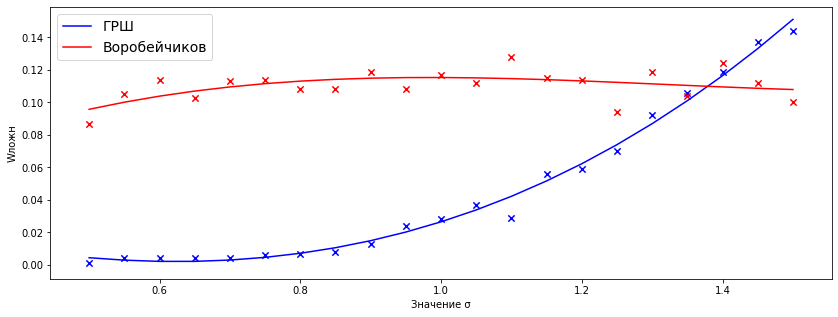

In [47]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее время запаздывания')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_t, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_t, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_t, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение времени запаздывания')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_sigma, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_sigma, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_sigma, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_w, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_w, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_w, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Варьируем среднеквадратичное (1)

In [50]:
%%time
# Показатели среднего времени запаздывания
lst_grsh_t = []
# Показатели относительной частоты ложного обнаружения
lst_grsh_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_grsh_sigma = []
# При различных значениях сигма
lst_sig = [a/20 for a in range(10, 31, 1)]
cpp = 600
N = 1000

for sig in lst_sig:
    # Для ГРШ
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1000,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=2
        )

        result = algorithm_grsh(seq=sequence, g=12, k=100)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_grsh_t.append(average_lag_time)
    lst_grsh_w.append(false_detection_probability)
    lst_grsh_sigma.append(std_time)

Wall time: 12min 59s


In [51]:
%%time
# Показатели среднего времени запаздывания
lst_vrb_t = []
# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_vrb_sigma = []

for sig in lst_sig: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1000,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=2
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=10)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_vrb_t.append(average_lag_time)
    lst_vrb_w.append(false_detection_probability)
    lst_vrb_sigma.append(std_time)

Wall time: 13min 17s


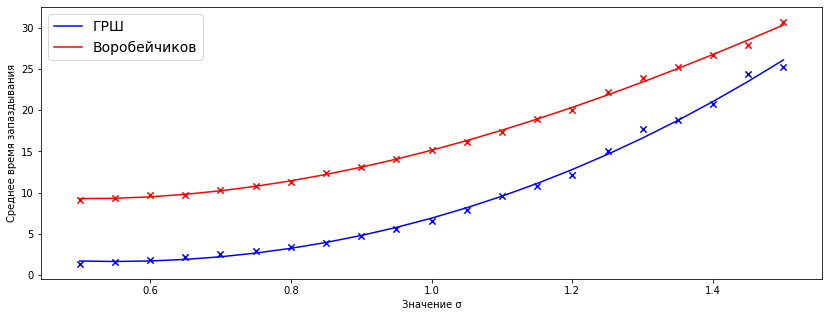

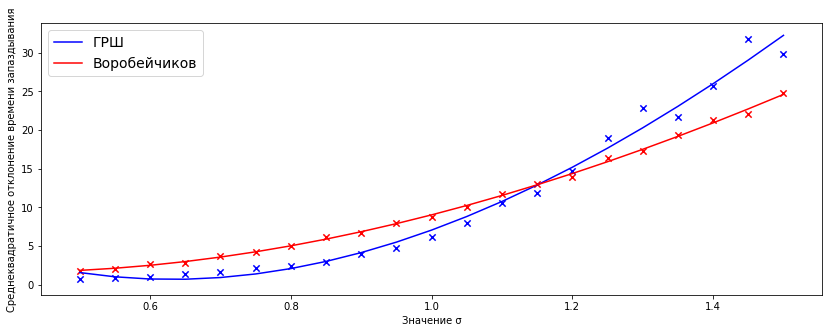

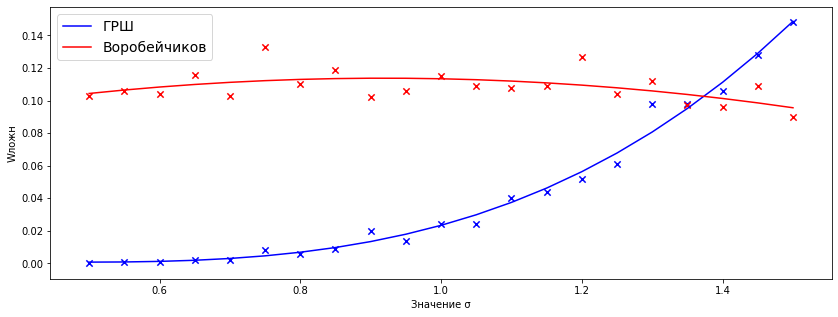

In [52]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее время запаздывания')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_t, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_t, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_t, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение времени запаздывания')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_sigma, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_sigma, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_sigma, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_w, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_w, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_w, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Варьируем изменение скачка среднего (1)

In [62]:
%%time
# Показатели среднего времени запаздывания
lst_grsh_t = []
# Показатели относительной частоты ложного обнаружения
lst_grsh_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_grsh_sigma = []
# При различных значениях сигма
lst_sig = [a/20 for a in range(40, 61, 1)]
cpp = 600
N = 1000

for sig in lst_sig:
    # Для ГРШ
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            mean_change=sig
        )

        result = algorithm_grsh(seq=sequence, g=12, k=100)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_grsh_t.append(average_lag_time)
    lst_grsh_w.append(false_detection_probability)
    lst_grsh_sigma.append(std_time)

Wall time: 13min 6s


In [63]:
%%time
# Показатели среднего времени запаздывания
lst_vrb_t = []
# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_vrb_sigma = []

for sig in lst_sig: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            mean_change=sig
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=10)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_vrb_t.append(average_lag_time)
    lst_vrb_w.append(false_detection_probability)
    lst_vrb_sigma.append(std_time)

Wall time: 13min 3s


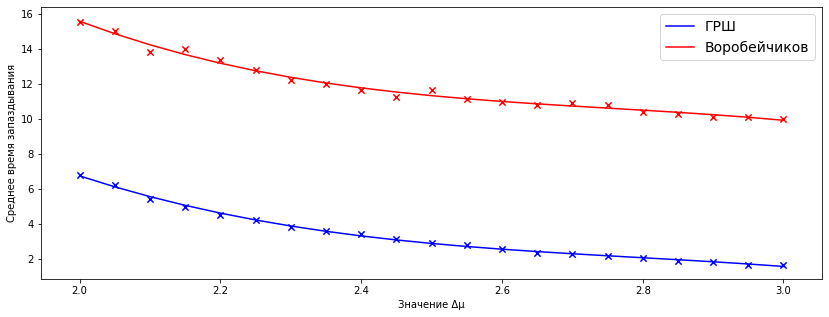

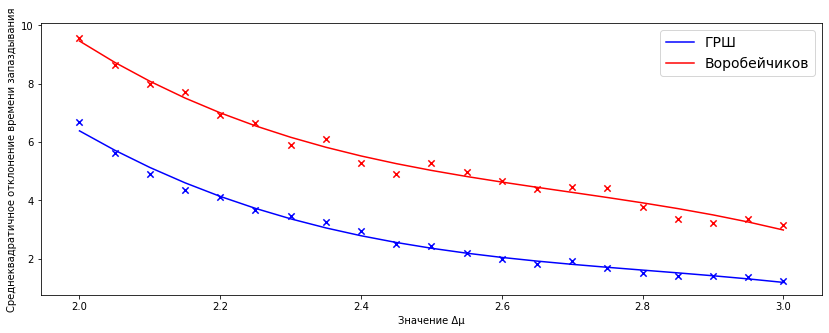

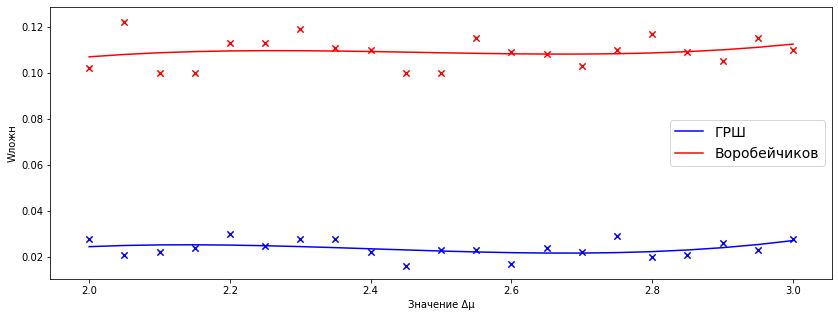

In [64]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее время запаздывания')
plt.xlabel('Значение Δμ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_t, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_t, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_t, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение времени запаздывания')
plt.xlabel('Значение Δμ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_sigma, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_sigma, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_sigma, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение Δμ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_w, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_w, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_w, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Варьируем изменение среднеквадратичного (3)

In [65]:
%%time
# Показатели среднего времени запаздывания
lst_grsh_t = []
# Показатели относительной частоты ложного обнаружения
lst_grsh_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_grsh_sigma = []
# При различных значениях сигма
lst_sig = [a/20 for a in range(20, 65, 5)]
cpp = 600
N = 1000

for sig in lst_sig:
    # Для ГРШ
    lst = []
    for i in range(N):    
        sequence = ChagePointDispersion(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            standard_deviation_change=sig
        )

        result = algorithm_grsh(seq=sequence, g=12, k=100)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_grsh_t.append(average_lag_time)
    lst_grsh_w.append(false_detection_probability)
    lst_grsh_sigma.append(std_time)

Wall time: 5min 52s


In [66]:
%%time
# Показатели среднего времени запаздывания
lst_vrb_t = []
# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_vrb_sigma = []

for sig in lst_sig: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointDispersion(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            standard_deviation_change=sig
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=10)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_vrb_t.append(average_lag_time)
    lst_vrb_w.append(false_detection_probability)
    lst_vrb_sigma.append(std_time)

Wall time: 9min 9s


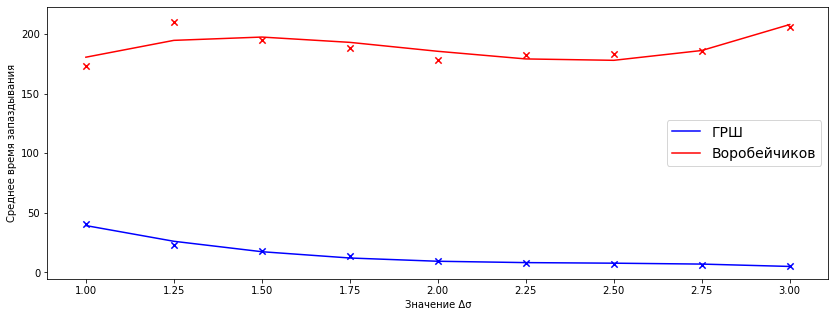

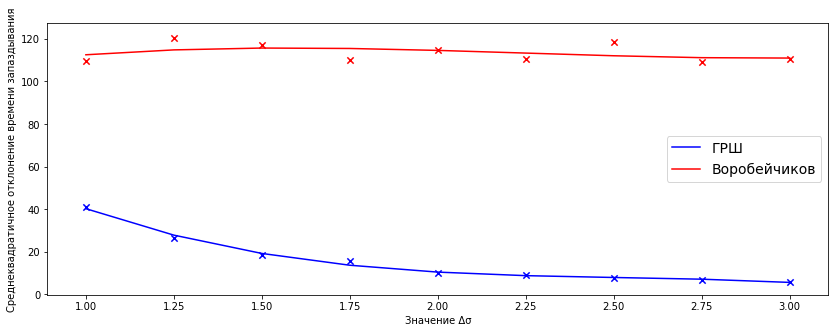

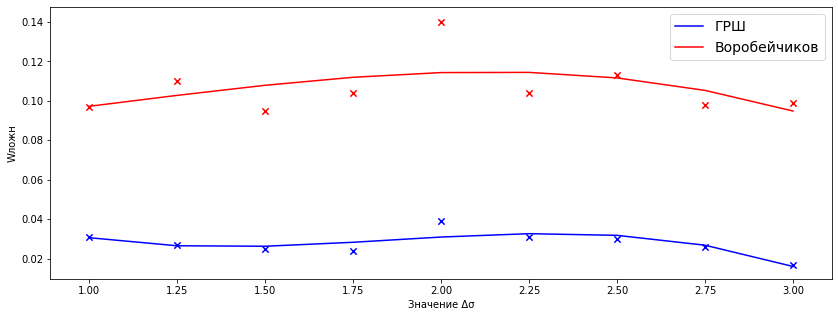

In [67]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее время запаздывания')
plt.xlabel('Значение Δσ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_t, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_t, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_t, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение времени запаздывания')
plt.xlabel('Значение Δσ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_sigma, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_sigma, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_sigma, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение Δσ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_w, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_w, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_w, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Варьируем позицию момента разладки (1)

In [8]:
%%time
# Показатели среднего времени запаздывания
lst_grsh_t = []
# Показатели относительной частоты ложного обнаружения
lst_grsh_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_grsh_sigma = []
# При различных значениях позиции
lst_theta = [a for a in range(200, 950, 50)]
N = 1000

for theta in lst_theta:
    # Для ГРШ
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=2
        )

        result = algorithm_grsh(seq=sequence, g=12, k=100)
        lst.append(result)
        
    lst_mean = [x-theta for x in lst if x >= theta]
    lst_freq = [x for x in lst if 0 < x < theta]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_grsh_t.append(average_lag_time)
    lst_grsh_w.append(false_detection_probability)
    lst_grsh_sigma.append(std_time)

Wall time: 10min 35s


In [9]:
%%time
# Показатели среднего времени запаздывания
lst_vrb_t = []
# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_vrb_sigma = []

for theta in lst_theta: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=2
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=12, t0=100)
        lst.append(result)
        
    lst_mean = [x-theta for x in lst if x >= theta]
    lst_freq = [x for x in lst if 0 < x < theta]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_vrb_t.append(average_lag_time)
    lst_vrb_w.append(false_detection_probability)
    lst_vrb_sigma.append(std_time)

Wall time: 10min 30s


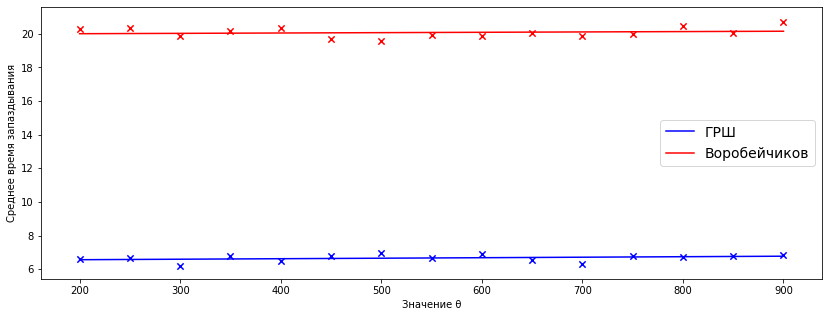

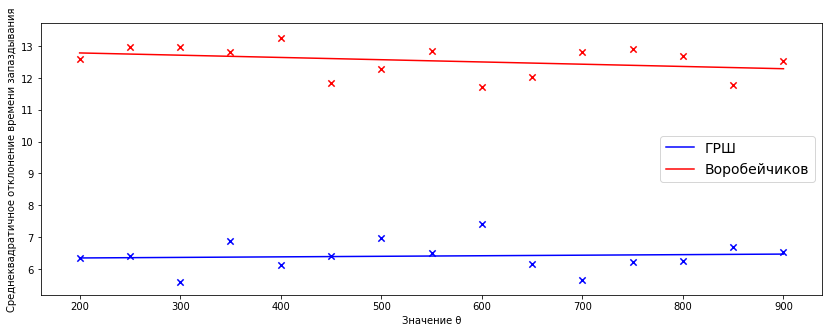

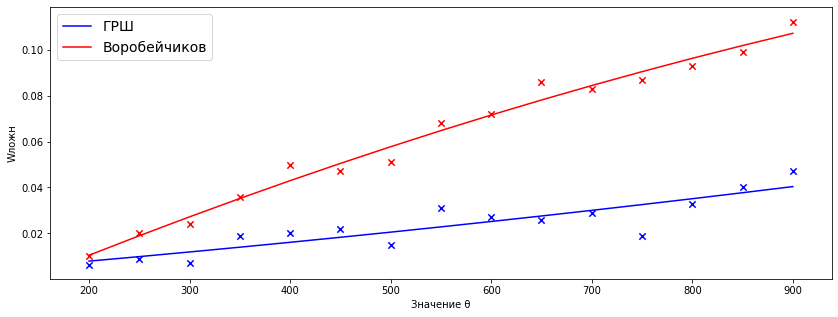

In [15]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее время запаздывания')
plt.xlabel('Значение θ')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_grsh_t, len(lst_theta), 1),
             color='blue',
             label='ГРШ')
plt.scatter(lst_theta, lst_grsh_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_vrb_t, len(lst_theta), 1),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_theta, lst_vrb_t, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение времени запаздывания')
plt.xlabel('Значение θ')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_grsh_sigma, len(lst_theta), 1),
             color='blue',
             label='ГРШ')
plt.scatter(lst_theta, lst_grsh_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_vrb_sigma, len(lst_theta), 1),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_theta, lst_vrb_sigma, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение θ')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_grsh_w, len(lst_theta), 2),
             color='blue',
             label='ГРШ')
plt.scatter(lst_theta, lst_grsh_w, color='blue', s=40, marker='x')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_vrb_w, len(lst_theta), 2),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_theta, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Варьируем длину последовательности (м1)

In [25]:
%%time
# Показатели среднего времени запаздывания
lst_grsh_t = []
# Показатели относительной частоты ложного обнаружения
lst_grsh_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_grsh_sigma = []
# При различных значениях длины последовательности
lst_n = [a for a in range(200, 950, 50)]
N = 1000

for n in lst_n:
    # Для ГРШ
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=n,
            mean=1, 
            standard_deviation=1,
            change_point_position=n//2,
            mean_change=2
        )

        result = algorithm_grsh(seq=sequence, g=12, k=100)
        lst.append(result)
        
    lst_mean = [x - n//2 for x in lst if x >= n//2]
    lst_freq = [x for x in lst if 0 < x < n//2]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_grsh_t.append(average_lag_time)
    lst_grsh_w.append(false_detection_probability)
    lst_grsh_sigma.append(std_time)

Wall time: 5min 32s


In [26]:
%%time
# Показатели среднего времени запаздывания
lst_vrb_t = []
# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_vrb_sigma = []

for n in lst_n:
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=n,
            mean=1, 
            standard_deviation=1,
            change_point_position=n//2,
            mean_change=2
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=12, t0=100)
        lst.append(result)
        
    lst_mean = [x - n//2 for x in lst if x >= n//2]
    lst_freq = [x for x in lst if 0 < x < n//2]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_vrb_t.append(average_lag_time)
    lst_vrb_w.append(false_detection_probability)
    lst_vrb_sigma.append(std_time)

Wall time: 6min 40s


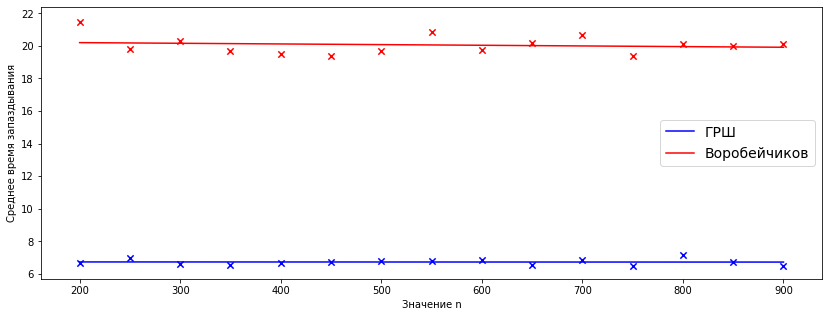

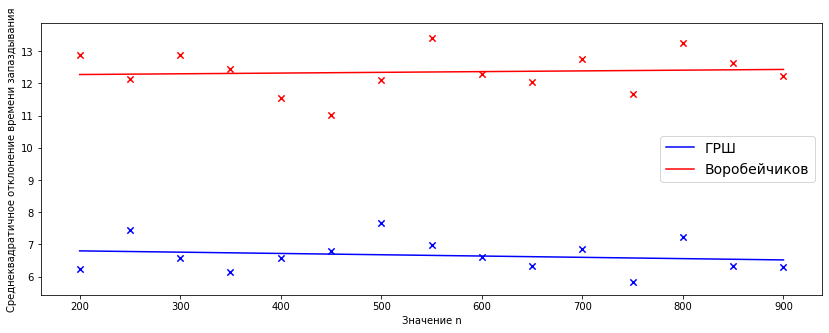

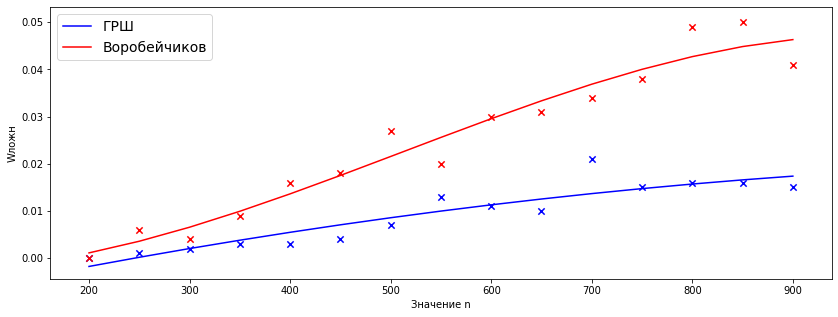

In [30]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее время запаздывания')
plt.xlabel('Значение n')

sns.lineplot(x=lst_n, 
             y=savgol_filter(lst_grsh_t, len(lst_n), 1),
             color='blue',
             label='ГРШ')
plt.scatter(lst_n, lst_grsh_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_n, 
             y=savgol_filter(lst_vrb_t, len(lst_n), 1),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_n, lst_vrb_t, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение времени запаздывания')
plt.xlabel('Значение n')

sns.lineplot(x=lst_n, 
             y=savgol_filter(lst_grsh_sigma, len(lst_n), 1),
             color='blue',
             label='ГРШ')
plt.scatter(lst_n, lst_grsh_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_n, 
             y=savgol_filter(lst_vrb_sigma, len(lst_n), 1),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_n, lst_vrb_sigma, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение n')

sns.lineplot(x=lst_n, 
             y=savgol_filter(lst_grsh_w, len(lst_n), 2),
             color='blue',
             label='ГРШ')
plt.scatter(lst_n, lst_grsh_w, color='blue', s=40, marker='x')

sns.lineplot(x=lst_n, 
             y=savgol_filter(lst_vrb_w, len(lst_n), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_n, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Черновик

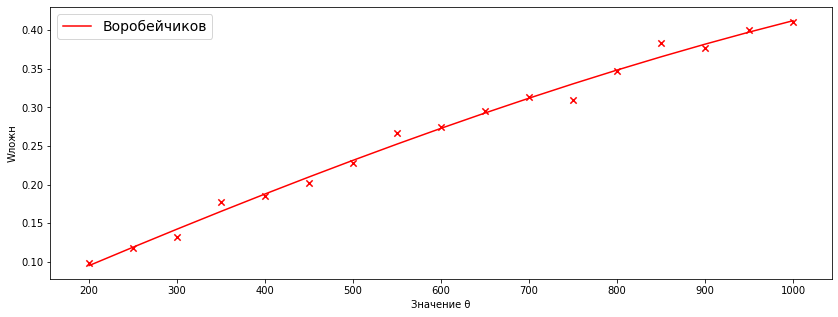

Wall time: 9min 57s


In [116]:
%%time

# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []

# При различных значениях позиции
lst_theta = [a for a in range(200, 1050, 50)]
N = 1000

for theta in lst_theta: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1200,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=2
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=10, t0=theta//10)
        lst.append(result)
        
    lst_freq = [x for x in lst if 0 < x < theta]
    false_detection_probability = len(lst_freq)/N
    lst_vrb_w.append(false_detection_probability)
    
    
plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение θ')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_vrb_w, len(lst_theta), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_theta, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

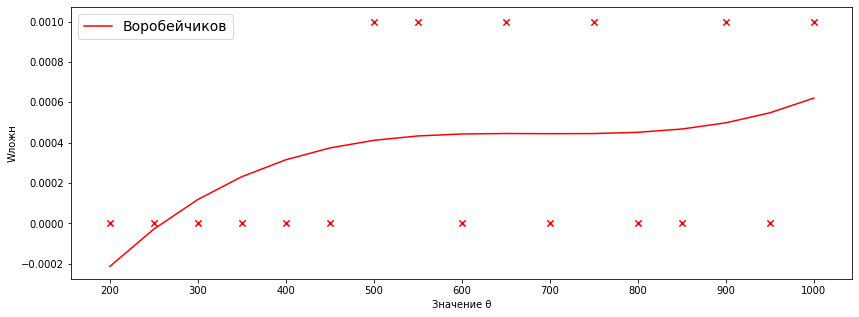

Wall time: 13min 13s


In [117]:
%%time

# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []

# При различных значениях позиции
lst_theta = [a for a in range(200, 1050, 50)]
N = 1000

for theta in lst_theta: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1200,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=2
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=20, t0=100)
        lst.append(result)
        
    lst_freq = [x for x in lst if 0 < x < theta]
    false_detection_probability = len(lst_freq)/N
    lst_vrb_w.append(false_detection_probability)
    
    
plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение θ')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_vrb_w, len(lst_theta), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_theta, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Варьируем t0 для алгоритма Воробейчикова

In [110]:
%%time
# Показатели среднего времени запаздывания
lst_vrb_t = []
# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_vrb_sigma = []

lst_t0 = [a for a in range(50, 601, 25)]
N = 1000
theta=700

for t0 in lst_t0: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=2
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=10, t0=t0)
        lst.append(result)
        
    lst_mean = [x-theta for x in lst if x >= theta]
    lst_freq = [x for x in lst if 0 < x < theta]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_vrb_t.append(average_lag_time)
    lst_vrb_w.append(false_detection_probability)
    lst_vrb_sigma.append(std_time)

Wall time: 16min 16s


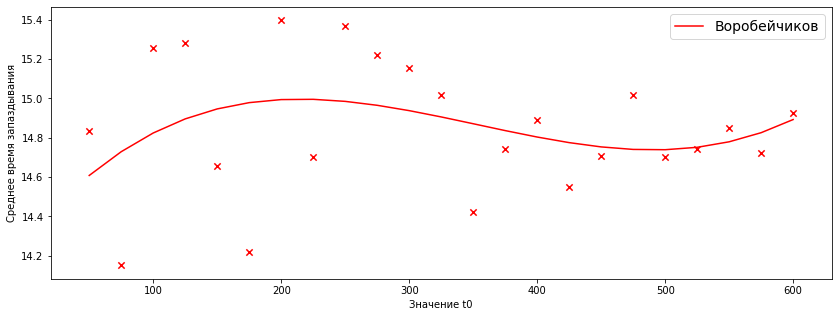

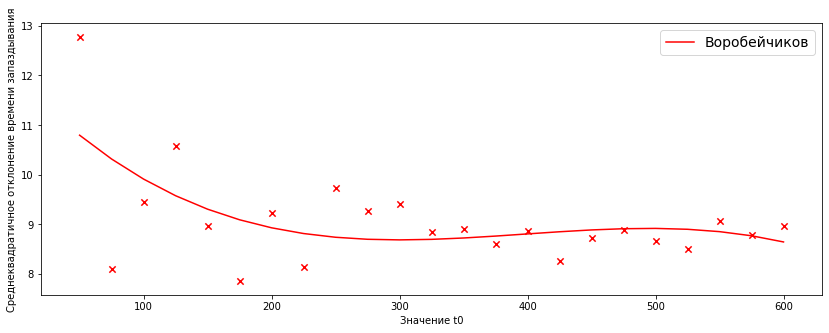

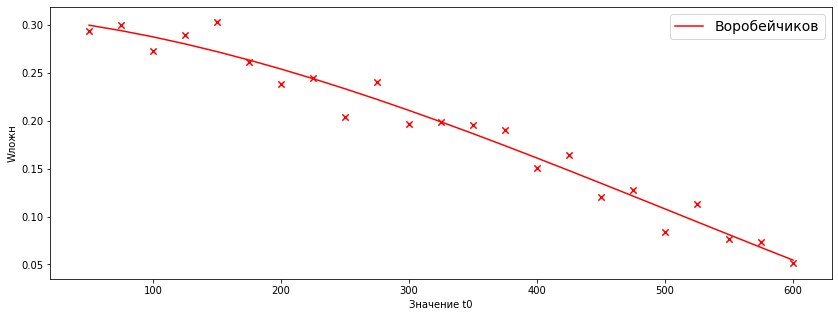

In [111]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее время запаздывания')
plt.xlabel('Значение t0')

sns.lineplot(x=lst_t0, 
             y=savgol_filter(lst_vrb_t, len(lst_t0), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_t0, lst_vrb_t, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение времени запаздывания')
plt.xlabel('Значение t0')

sns.lineplot(x=lst_t0, 
             y=savgol_filter(lst_vrb_sigma, len(lst_t0), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_t0, lst_vrb_sigma, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение t0')

sns.lineplot(x=lst_t0, 
             y=savgol_filter(lst_vrb_w, len(lst_t0), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_t0, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()